# Civic Analysis & Urban Intelligence
# Problem Set 1
# By: Yukun Wan / yw3447



# 1. Problem:
##    Are noise complaints associated with the number of restaurants around?


# 2. Descriptive statistics

### Sample: All noise complaints from Manhattan in Year 2016
### (1) Find all noise complaints from 311 dataset. Group complaints by Zip Code

In [97]:
from __future__ import print_function

import argparse
import json
import pprint
import requests
import sys
import urllib
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import statsmodels.formula.api as smf
%pylab inline

# This client code can run on Python 2.x or 3.x.  Your imports can be
# simpler if you only need one of those.
try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['box', 'sample', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv("311_Service_Requests_from_2014_to_Present.csv")

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,17,40,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data[data['Complaint Type'] == 'Noise']

In [4]:
data['Created Date'] = pd.to_datetime(data['Created Date'],format='%m/%d/%Y %H:%M:%S %p')
data['year'] = data['Created Date'].dt.year
data['month'] = data['Created Date'].dt.month

In [5]:
data = data[data['year'] == 2016]
data = data[data['Borough'] == 'MANHATTAN']
len(data)

28016

In [6]:
data.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location,year,month
2809757,32310854,2016-01-01 12:30:00,01/04/2016 10:51:00 AM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,10028,445 EAST 83 STREET,...,NaN,NaN,NaN,NaN,NaN,40.774494,-73.949749,"(40.77449445696748, -73.94974924771603)",2016,1
2810905,32313686,2016-01-01 05:37:00,01/13/2016 12:15:00 AM,DEP,Department of Environmental Protection,Noise,"Noise, Barking Dog (NR5)",NaN,10065,347 EAST 65 STREET,...,NaN,NaN,NaN,NaN,NaN,40.763893,-73.960471,"(40.763892957779426, -73.96047146564446)",2016,1
2811155,32312627,2016-01-01 08:42:00,01/05/2016 12:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10001,303 WEST 29 STREET,...,NaN,NaN,NaN,NaN,NaN,40.749256,-73.996210,"(40.74925646171696, -73.99621042550633)",2016,1
2811300,32313366,2016-01-01 09:42:00,01/05/2016 12:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10128,NaN,...,NaN,NaN,NaN,NaN,NaN,40.782633,-73.951198,"(40.78263322355763, -73.95119830954191)",2016,1
2811396,32311070,2016-01-01 10:26:00,01/06/2016 08:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: air condition/ventilation equipment (NV1),NaN,10016,325 EAST 38 STREET,...,NaN,NaN,NaN,NaN,NaN,40.746797,-73.972828,"(40.7467967690866, -73.97282794914913)",2016,1


In [7]:
data = data.dropna(subset=['Incident Zip'])

In [8]:
len(data)

27866

In [22]:
incident = data.groupby(['Incident Zip']).size().to_frame().reset_index()

In [23]:
incident.columns = ['ZipCode','IncidentNumber']

In [38]:
incident['ZipCode'] = incident['ZipCode'].astype(str)

In [39]:
incident.head()

,ZipCode,IncidentNumber,RestaurantNumber
0,10001,866,0.0
1,10002,758,0.0
2,10003,698,1.0
3,10004,155,0.0
4,10005,188,2.0


### (2) Import Yelp API

In [46]:
# OAuth credential placeholders that must be filled in by users.
# You can find them on
# https://www.yelp.com/developers/v3/manage_app
CLIENT_ID = 'Uu3HbS4pg129T9EGGOQ4HQ'
CLIENT_SECRET = 'XxfmwtVRRKOsemtPWz8DVS9aazZX4O5mX5wilDCmy0JI6LJxlei6QHafROZazaCb'


# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
TOKEN_PATH = '/oauth2/token'
GRANT_TYPE = 'client_credentials'

# Defaults for our simple example.
DEFAULT_TERM = 'dinner'
DEFAULT_LOCATION = 'San Francisco, CA'
SEARCH_LIMIT = 3

def obtain_bearer_token(host, path):
    """Given a bearer token, send a GET request to the API.

    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        url_params (dict): An optional set of query parameters in the request.

    Returns:
        str: OAuth bearer token, obtained using client_id and client_secret.

    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    assert CLIENT_ID, "Please supply your client_id."
    assert CLIENT_SECRET, "Please supply your client_secret."
    data = urlencode({
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
        'grant_type': GRANT_TYPE,
    })
    headers = {
        'content-type': 'application/x-www-form-urlencoded',
    }
    response = requests.request('POST', url, data=data, headers=headers)
    bearer_token = response.json()['access_token']
    return bearer_token

def request(host, path, bearer_token, url_params=None):
    """Given a bearer token, send a GET request to the API.

    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        bearer_token (str): OAuth bearer token, obtained using client_id and client_secret.
        url_params (dict): An optional set of query parameters in the request.

    Returns:
        dict: The JSON response from the request.

    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % bearer_token,
    }

    #print(u'Querying {0} ...'.format(url))

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

### (3) Set Search in Yelp function: use Term and Location(Zip Code) to find bars/restaurants

In [47]:
def search(bearer_token, term, location):
    """Query the Search API by a search term and location.

    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.

    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': SEARCH_LIMIT,
    }
    return request(API_HOST, SEARCH_PATH, bearer_token, url_params=url_params)

In [48]:
bearer_token = obtain_bearer_token(API_HOST, TOKEN_PATH)

### (4) Find the total number of restaurants/bars for each Zip Code

In [51]:
incident['RestaurantNumber'] = pd.Series(np.zeros(len(incident)), index=incident.index)

In [52]:
for i in range(len(incident)):
    a = incident.loc[i].ZipCode
    response = search(bearer_token, 'restaurants', 'NY ' + a)
    incident.at[i,'RestaurantNumber'] = response['total']

In [53]:
incident.head()

,ZipCode,IncidentNumber,RestaurantNumber
0,10001,866,5865.0
1,10002,758,4174.0
2,10003,698,5500.0
3,10004,155,751.0
4,10005,188,1046.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1e04c21d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1e0454050>]], dtype=object)

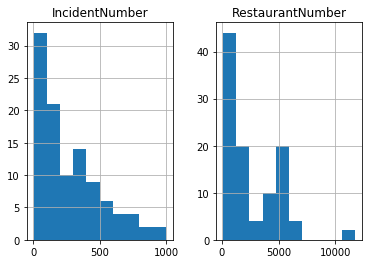

In [87]:
sample = incident.drop(['ZipCode'],axis=1)
sample.hist()

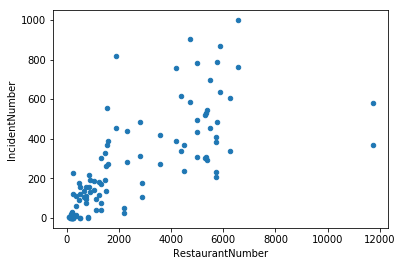

In [89]:
sample.plot(kind='scatter',x='RestaurantNumber',y='IncidentNumber')

# 3. Visualization

### map the locations of 311 complaints for noise based on Zip Code

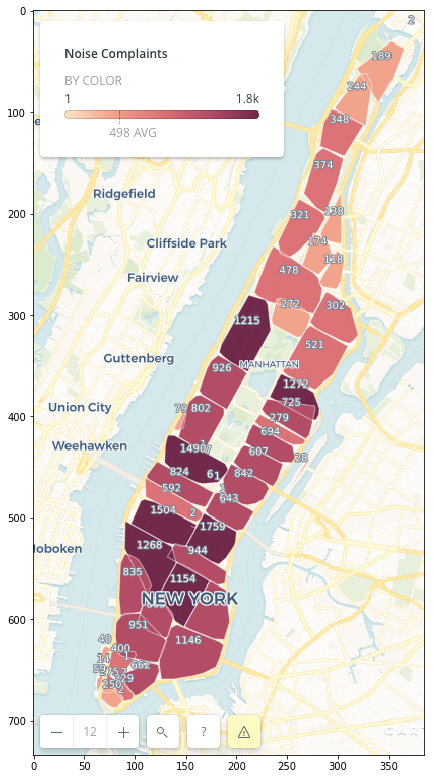

In [116]:
img=mpimg.imread('311_noise.png')
fig = plt.figure(figsize = (7,14))
ax = fig.add_subplot(111)
ax.imshow(img, interpolation='nearest')
plt.show()

# 4. Analysis

### Apply Linear Regression to Noise Incident Number and Restaurant Number based on Zip Code

### R-squared = 0.516, which means that the more restaurants an area has, the more noise complaints this area gets

In [57]:
lm = smf.ols(formula='IncidentNumber ~ RestaurantNumber', data = incident).fit()

In [60]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         IncidentNumber   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     108.7
Date:                Sat, 07 Oct 2017   Prob (F-statistic):           9.28e-18
Time:                        23:10:55   Log-Likelihood:                -682.56
No. Observations:                 104   AIC:                             1369.
Df Residuals:                     102   BIC:                             1374.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           84.9933     24.414      3.481      0.001      36.569     133.418
RestaurantNumber     0.0713      0.007     10.426      0.000       0.058       0.085
==============================================================================
Omnibus:                       16.571   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.471
Skew:                           0.721   Prob(JB):                     2.94e-06
Kurtosis:                       4.948   Cond. No.                     5.13e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.13e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

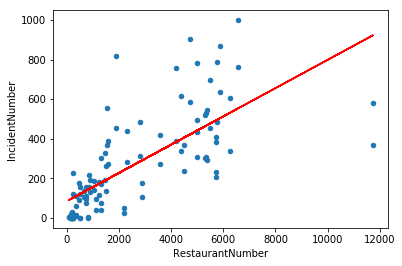

In [59]:
incident.plot(kind='scatter',x='RestaurantNumber',y='IncidentNumber')
pl.plot(incident.RestaurantNumber,lm.predict(),'r-')


# 5. Discussion

### How an agency might use your findings to improve service delivery or performance?
#### The agencies related can arrange resources more efficiently based on my finding - pay more attentions to the areas where lots of restaurants gather.

### What agency(ies) would be involved? 
#### Department of Environmental Protection

### What are the limitations of your approach? 
#### The search results from Yelp may not cover all the restaurants. Some noisy small restaurants may not be listed. Some bars providing meals may not be classfied as "Restaurants" as well. Besides, the search results based on Zip Code may overlap because Yelp may apply fuzzy search and includes some restaurants nearby but outside the specific Zip Code area.

### What could you do to improve it?
#### I would use multiple key words (like "Restaurants", "Bars", "Foods", "Beers", "Party") and remove the overlapped results. Also I would set function to ensure all the results belongs to my restrictions on location. Then I may find which types of restaurants are the most associated with noise.